We implement the Inverse Laplace tranform approximation for the CC normalizing constant. We analyze the accuracy of the approximation as a function of the dimension, and compare to the standard implementation.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from mpmath import invertlaplace, nprod, mp, matrix, exp, diag, log, factorial, workdps, fprod
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import json

In [2]:
# Set up parameters

# The standard deviations of the normal distributions from which eta is drawn
sigmas = 10.0 ** np.array([-5, -3, -2, -1, -0.5, 0, 0.5, 1.0, 2, 3, 5])
sigmas = 10.0 ** np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2])
# The number of replicates for each sigma, used to construct error bars
num_seeds = 10
# The range of dimensions to test out for each sigma
Ks = range(3, 42)
# The percentage error on the normalizing constant under which we consider it correct
tol = 0.01
# Set seed
np.random.seed(0)


In [3]:
# Declare functions for computing the normalizing constant

# "Vanilla" TF implementation, as per CC paper
def cc_log_norm_const(eta):
    # Compute the log-normalizing-constant of the CC distribution
    # See paper/supplement for mathematical details
    n, K = eta.shape
    dtype = eta.dtype
    eta_np = tf.stop_gradient(eta)
    sds = tf.math.reduce_std(eta_np, axis=1)
    scaling_factors = sds / 1.0
    aug_eta = tf.concat([eta, tf.zeros([n,1], dtype=dtype)], -1)
    lam = tf.math.softmax(aug_eta, axis=1)
    aug_eta = aug_eta / tf.reshape(scaling_factors, [n,1])
    rows = tf.reshape(aug_eta, [n, -1, 1])
    cols = tf.reshape(aug_eta, [n, -1, K+1])
    eta_diffs = rows - cols
    eta_diffs = eta_diffs + tf.eye(K+1, dtype=dtype)
    dens = tf.reduce_prod(eta_diffs, axis=1)
    res = - tf.math.log((-1)**K * tf.reduce_sum(lam / dens, axis=1)) +\
        K * tf.math.log(scaling_factors)
    return res

# Implementation using the mpmath library, allowing for user-specified precision
def cc_log_norm_const_mpmath(eta, dps=None):
    # Convert into mpmath format and carry out the computations there:
    n, K = eta.shape[0], eta.shape[1] + 1
    # set the precision we need:
    if dps is None:
        dps = 10 + 6 * K

    with workdps(dps):
        dtype = eta.dtype
        aug_eta = tf.concat([eta, tf.zeros([n,1], dtype=dtype)], -1).numpy()
        res = []
    
        for i in range(n):
            mp_eta = matrix(aug_eta[i].tolist())
    
            # Initialize C:
            C = matrix(K, 1) + 1.0
            for k in range(0, K-1):
                xi = mp_eta[k:k+1][0] - mp_eta[k+1:]
                C_left = C[0:1]
                C_right = C[1:]
                num = xi.apply(exp) * C_left[0] - C_right
                den = xi
                # workaround way to perform element-wise division with mpmath:
                C = diag(num) * den.apply(lambda x: 1/x)
                # C = (xi.apply(exp) * C_left[0] - C_right) / xi
    
            if C[0] < 0:
                return [np.nan]
    
            res.append(float(- log(C[0]) + tf.math.reduce_logsumexp(aug_eta[i]).numpy()))

    return res

# Computes the CC normalizing constant exactly using mpmath, 
# by increasing the precision until the result no longer changes.
def cc_log_norm_const_mpmath_exact(eta):
    dps = 10 + 3 * K
    exact1 = cc_log_norm_const_mpmath(eta, dps=dps)[0]
    finished = False
    while not finished:
        dps += 5
        exact2 = cc_log_norm_const_mpmath(eta, dps=dps)[0]
        if abs((exact1 - exact2) / exact2) < 0.001:
            finished = True
            out = exact2
        exact1 = exact2
    return out


In [4]:
# An example of catastrophic cancellation
K = 40 # Adjust to see different behavior
dtype = 'float32' # float64
eta = tf.cast(np.arange(1, K), dtype=dtype)
aug_eta = tf.concat([eta, [0]], axis=-1)
rows = tf.reshape(aug_eta, [-1, 1])
cols = tf.reshape(aug_eta, [1, -1])
eta_diffs = cols - rows
eta_diffs = eta_diffs + tf.eye(K, dtype=dtype)
dens = tf.reduce_prod(eta_diffs, axis=0)
nums = tf.exp(aug_eta)
print(nums / dens)
print(tf.reduce_sum(nums / dens))

tf.Tensor(
[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00
  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -8.9911141e-36
  8.4183539e-35 -6.8650385e-34  4.9197469e-33 -3.1204270e-32
  1.7616872e-31 -8.8934179e-31  4.0291365e-30 -1.6428492e-29
  6.0418661e-29 -2.0073161e-28  6.0308137e-28 -1.6393450e-27
  4.0318011e-27 -8.9669234e-27  1.8016028e-26 -3.2648429e-26
  5.3248586e-26 -7.7939420e-26  1.0200727e-25 -1.1883627e-25
  1.2252875e-25 -1.1102260e-25  8.7616636e-26 -0.0000000e+00
  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00
  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00], shape=(40,), dtype=float32)
tf.Tensor(3.684572e-26, shape=(), dtype=float32)


/Users/elliott/miniconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in log


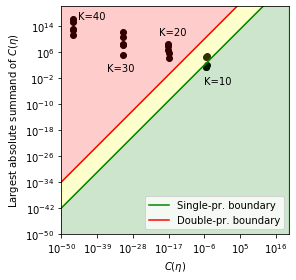

In [5]:
# Illustrate catastrophic cancellation as K varies
def logstd(x):
    return np.exp(np.std(np.log(x)))
for sigma in [1]:
    for K in [10, 20, 30, 40]:
#     for K in [5, 10, 15, 20]:
        x = []
        y = []
        for seed in range(5):
            eta = np.random.randn(K-1) * sigma
            tf_eta = tf.cast(eta, dtype='float32')
            aug_eta = tf.concat([tf_eta, [0]], axis=-1)
            rows = tf.reshape(aug_eta, [-1, 1])
            cols = tf.reshape(aug_eta, [1, -1])
            eta_diffs = cols - rows
            eta_diffs = eta_diffs + tf.eye(K, dtype='float32')
            dens = tf.reduce_prod(eta_diffs, axis=0)
            nums = tf.exp(aug_eta)
            y.append(np.max(np.abs(nums / dens)))
            exact = - cc_log_norm_const_mpmath_exact(tf.reshape(tf_eta, [1, -1])) + tf.math.reduce_logsumexp(aug_eta).numpy()
            x.append(np.exp(exact))
            
        logx = np.log(x)
        logy = np.log(y)

#         xmean = np.mean(logx)
#         ymean = np.mean(logy)
#         xerr = [[np.exp(xmean) - np.exp(xmean - 2*np.std(logx))], [np.exp(xmean + 2*np.std(logx)) - np.exp(xmean)]]
#         yerr = [[np.exp(ymean) - np.exp(ymean - 2*np.std(logy))], [np.exp(ymean + 2*np.std(logy)) - np.exp(ymean)]]
#         xerr = [[np.exp(xmean) - min(x)], [max(x) - np.exp(xmean)]]
#         yerr = [[np.exp(ymean) - min(y)], [max(y) - np.exp(ymean)]]
#         plt.errorbar(np.exp(xmean), np.exp(ymean), xerr=xerr, yerr=yerr, fmt='o', color='black')
        plt.scatter(x, y, color='black')

plt.annotate("K=10", (1e-6, 1e-4))
plt.annotate("K=20", (1e-20, 1e11))
plt.annotate("K=30", (1e-36, 1e0))
plt.annotate("K=40", (1e-45, 1e16))

# plt.annotate("K=5", (1e-2, 1e-2))
# plt.annotate("K=10", (1e-8, 1e6))
# plt.annotate("K=15", (0.4e-13, 1e0))
# plt.annotate("K=20", (3e-20, 1e2))

# xmin = min(x)
# xmax = max(x)
# plt.plot([xmin, xmax], [xmin * 10e8, xmax * 10e8])
ax = plt.gca()
# ax.invert_xaxis()
# ax.invert_yaxis()
ax.set_aspect("equal", "box")
plt.xscale('log')
plt.yscale('log')
lims = np.array([1e-50, 1e20])
# lims = np.array([1e-20, 1e10])
plt.plot(lims, lims * 1e8, color='green', label='Single-pr. boundary')
plt.plot(lims, lims * 1e16, color='red', label='Double-pr. boundary')

alpha=0.2
ax.fill_between(lims, lims*0, lims*1e8, color='green', alpha=alpha)
ax.fill_between(lims, lims*1e8, lims*1e16, color='yellow', alpha=alpha)
ax.fill_between(lims, lims*1e16, lims*1e100, color='red', alpha=alpha)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("$C(\eta)$")
plt.ylabel("Largest absolute summand of $C(\eta)$")
# plt.axis("equal")
plt.legend()

plt.tight_layout()
plt.savefig('./scaling.pdf')


In [6]:
# Lists to store results for plotting later

float32_mpmath_means = []
float32_mpmath_stds = []
float64_mpmath_means = []
float64_mpmath_stds = []

dehoog_means = []
dehoog_stds = []
stehfest_means = []
stehfest_stds = []

float32_tf_means = []
float32_tf_stds = []
float64_tf_means = []
float64_tf_stds = []

factorial_means = []
factorial_stds = []

For each sigma in sigmas and each dimension in Ks, we draw a random vector of etas and compare the approximations
to the exact value of the normalizing constant. For each sigma we store the maximum dimension that was computable
under each method, with error-bars over random seeds.

In [7]:


for sigma in sigmas:
    print("Calculating normalizing constants for Sigma =", sigma)
    float32_tf = []
    float64_tf = []
    float32_mpmath = []
    float64_mpmath = []
    stehfest = []
    dehoog = []
    factorials = []
    all_methods = [float32_tf, float64_tf, float32_mpmath, float64_mpmath, stehfest, dehoog, factorials]
    for seed in range(num_seeds):
        for K in Ks:
            eta = np.random.normal(np.zeros(K - 1)).reshape([1, -1]) * sigma

            eta_laplace = list(eta[0,:])
            eta_laplace.append(0)

            eta = tf.convert_to_tensor(eta.reshape([1, -1]), dtype='float32')
            n = eta.shape[0]
            dtype = eta.dtype
            aug_eta = tf.concat([eta, tf.zeros([n, 1], dtype=dtype)], -1)

            # First calculate the true normalizing constant
            exact = - cc_log_norm_const_mpmath_exact(eta)

#             if (len(float32_mpmath) == seed):
#                 val = - cc_log_norm_const_mpmath(eta, prec=23)[0]
#                 if abs((val - exact) / exact) > tol:
#                     float32_mpmath.append(K)

#             if (len(float64_mpmath) == seed):
#                 val = - cc_log_norm_const_mpmath(eta, prec=53)[0]
#                 if abs((val - exact) / exact) > tol:
#                     float64_mpmath.append(K)

#             def laplace(s):
#                 out = 1.0
#                 for i in range(len(eta_laplace)):
#                     out = out * (exp(eta_laplace[i] - s) - 1) / (eta_laplace[i] - s)
#                 return out

            def laplace(s):
                out = 0.0
                mp_eta_laplace = matrix(eta_laplace)
                return 1 / fprod(s - mp_eta_laplace) #* fprod(1 - exp(mp_eta_laplace - s))


#             def laplace(s):
#                 out = 0.0
#                 for i in range(len(eta_laplace)):
#                     out = out + log(exp(eta_laplace[i] - s) - 1) - log(eta_laplace[i] - s)
#                 return exp(out)

            if (len(dehoog) == seed):
                try:
                    val = float(log(invertlaplace(laplace, 1.0, method='dehoog')).real)
                    val -= tf.math.reduce_logsumexp(aug_eta, axis=1).numpy()[0]
                except:
                    val = np.inf
                if abs((val - exact) / exact) > tol:
                    dehoog.append(K)

            if (len(stehfest) == seed):
                try:
                    val = float(log(invertlaplace(laplace, 1.0, method='stehfest')).real)
                    val -= tf.math.reduce_logsumexp(aug_eta, axis=1).numpy()[0]
                except:
                    val = np.inf
                if abs((val - exact) / exact) > tol:
                    stehfest.append(K)

            if (len(factorials) == seed):
                val = float(-log(factorial(K)))
                if abs((val - exact) / exact) > tol:
                    factorials.append(K)

            if (len(float32_tf) == seed):
                val = - cc_log_norm_const(eta)
                val = val.numpy()[0]
                if abs((val - exact) / exact) > tol:
                    float32_tf.append(K)

            if (len(float64_tf) == seed):
                eta = tf.cast(eta, dtype='float64')
                aug_eta = tf.cast(aug_eta, dtype='float64')
                val = - cc_log_norm_const(eta)
                val = val.numpy()[0]
                if abs((val - exact) / exact) > tol:
                    float64_tf.append(K)

            if all([len(x) == seed + 1 for x in all_methods]):
                break

        for x in all_methods:
            if len(x) != seed + 1:
                x.append(K + 1)

#     float32_mpmath_means.append(np.mean(float32_mpmath))
#     float32_mpmath_stds.append(np.std(float32_mpmath))
#     float64_mpmath_means.append(np.mean(float64_mpmath))
#     float64_mpmath_stds.append(np.std(float64_mpmath))

    dehoog_means.append(np.mean(dehoog))
    dehoog_stds.append(np.std(dehoog))
    stehfest_means.append(np.mean(stehfest))
    stehfest_stds.append(np.std(stehfest))

    float32_tf_means.append(np.mean(float32_tf))
    float32_tf_stds.append(np.std(float32_tf))
    float64_tf_means.append(np.mean(float64_tf))
    float64_tf_stds.append(np.std(float64_tf))

    factorial_means.append(np.mean(factorials))
    factorial_stds.append(np.std(factorials))
    
    results = {
        "dehoog_means": dehoog_means,
        "dehoog_stds": dehoog_stds,

        "stehfest_means": stehfest_means,
        "stehfest_stds": stehfest_stds,

        "float32_tf_means": float32_tf_means,
        "float32_tf_stds": float32_tf_stds,

        "float64_tf_means": float64_tf_means,
        "float64_tf_stds": float64_tf_stds,

        "factorial_means": factorial_means,
        "factorial_stds": factorial_stds,
    }
    file = open("backup.json", "w")
    json.dump(results, file)
    

Calculating normalizing constants for Sigma = 0.01
Calculating normalizing constants for Sigma = 0.03162277660168379
Calculating normalizing constants for Sigma = 0.1
Calculating normalizing constants for Sigma = 0.31622776601683794
Calculating normalizing constants for Sigma = 1.0
Calculating normalizing constants for Sigma = 3.1622776601683795
Calculating normalizing constants for Sigma = 10.0
Calculating normalizing constants for Sigma = 31.622776601683793
Calculating normalizing constants for Sigma = 100.0


In [8]:

# # If necessary can reload using:
# file = open("backup.json", "r")
# output = json.loads(file.read())
# print(output)
# dehoog_means = output['dehoog_means']
# dehoog_stds = output['dehoog_stds']
# stehfest_means = output['stehfest_means']
# stehfest_stds = output['stehfest_stds']
# float32_tf_means = output['float32_tf_means']
# float32_tf_stds = output['float32_tf_stds']
# float64_tf_means = output['float64_tf_means']
# float64_tf_stds = output['float64_tf_stds']
# factorial_means = output['factorial_means']
# factorial_stds = output['factorial_stds']


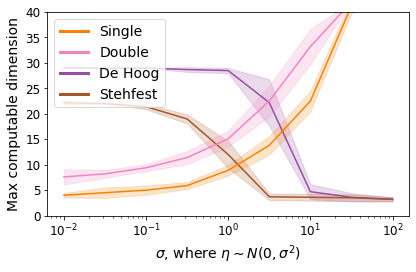

In [9]:
# Plot the results


###################################
# Required to avoid type3 fonts 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
###################################

###################################
# Storing colors here
blue = "#377eb8"
purple = "#984ea3"
orange = "#ff7f00"
brown = "#a65628"
pink = "#f781bf"
grey = "#999999"
# green = "#4daf4a"
# red = "#e41a1c"
# yellow = "#ffff33"
####################################

matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
# plt.ylim(-45,15)


alpha=0.2

fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(sigmas, dehoog_means, color=purple)
ax.fill_between(sigmas, np.subtract(dehoog_means, dehoog_stds), np.add(dehoog_means, dehoog_stds), color=purple, alpha=alpha)
ax.plot(sigmas, stehfest_means, color=brown)
ax.fill_between(sigmas, np.subtract(stehfest_means, stehfest_stds), np.add(stehfest_means, stehfest_stds), color=brown, alpha=alpha)
# float64_tf_means[7] = 55 # this should be about right but would take forever to compute
ax.plot(sigmas, float64_tf_means, color=pink)
ax.fill_between(sigmas, np.subtract(float64_tf_means, float64_tf_stds), np.add(float64_tf_means, float64_tf_stds), color=pink, alpha=alpha)
ax.plot(sigmas, float32_tf_means, color=orange)
ax.fill_between(sigmas, np.subtract(float32_tf_means, float32_tf_stds), np.add(float32_tf_means, float32_tf_stds), color=orange, alpha=alpha)
# ax.plot(sigmas, float64_mpmath_means, color=blue)
# ax.fill_between(sigmas, np.subtract(float64_mpmath_means, float64_mpmath_stds), np.add(float64_mpmath_means, float64_mpmath_stds), color=blue, alpha=alpha)
# ax.plot(sigmas, factorial_means, color=blue)
# ax.fill_between(sigmas, np.subtract(factorial_means, factorial_stds), np.add(factorial_means, factorial_stds), color=blue, alpha=alpha)

ax.set_xlabel('$\sigma$, where $\eta \sim N(0,\sigma^2)$')
ax.set_ylabel('Max computable dimension')

plt.xscale('log')
# plt.xlim(0, 11)
plt.ylim(0, 40)

custom_lines = [
    Line2D([0], [0], lw=3, color=orange),
    Line2D([0], [0], lw=3, color=pink),
    Line2D([0], [0], lw=3, color=purple),
    Line2D([0], [0], lw=3, color=brown),
#     Line2D([0], [0], lw=3, color=blue),
                ]
plt.legend(custom_lines, [ 'Single', 'Double', 'De Hoog', 'Stehfest'], loc='upper left')

# plt.title("A Title")
plt.tight_layout()
plt.savefig('./laplace.pdf')
plt.show()
